In [3]:
%load_ext autoreload
%autoreload 1
from orangecontrib.bio.ontology import OBOOntology
import networkx as nx
%matplotlib inline
from pylab import * 
from itertools import repeat
%aimport network_tools
from network_tools import *
import pandas as pd
import re

# Building Hiearchical Sample Networks from the Ontology
#### Why should we actually bother?
* We get an overview over what cell signatures are feasible
* We can compare the network to computational clustering 
* We can set a 'cut-off' on a certain hieararchy level and group samples together to form one cell signature

Here I will investigate if the ontology provides information that is fine-grained enough for our purposes. 

## First experiments

In [4]:
obo = OBOOntology()
obo.load(open("data/ff-phase2-140729.obo"))

In [5]:
obo.root_terms()

[OBOObject(id='BFO:0000040', name=material entity, ...),
 OBOObject(id='DOID:4', name=disease, ...),
 OBOObject(id='EFO:0000001', name=experimental factor, ...),
 OBOObject(id='FF:0000001', name=sample, ...),
 OBOObject(id='GO:0005575', name=cellular_component, ...),
 OBOObject(id='NCBITaxon:1', name=root, ...),
 OBOObject(id='UBERON:0001062', name=anatomical entity, ...)]

In [6]:
obo.child_terms("FF:0000001")

{OBOObject(id='FF:0000101', name=sample by species, ...),
 OBOObject(id='FF:0000350', name=experimentally modified sample, ...),
 OBOObject(id='FF:0000102', name=sample by type, ...)}

In [7]:
obo.child_terms("FF:0000102")

{OBOObject(id='FF:0000003', name=cell line sample, ...),
 OBOObject(id='FF:0000002', name=in vivo cell sample, ...),
 OBOObject(id='FF:0000004', name=tissue sample, ...)}

Essentially, I want to build a sub-tree of the DAG, starting at 'sample'

### Experiments with networkX
NetworkX looks like a promising library to manipulate graphs created from the Ontology 

In [8]:
G1 = obo.to_networkx(terms=["FF:0000002"])

In [9]:
G1_ = relabel_nodes(obo, G1)

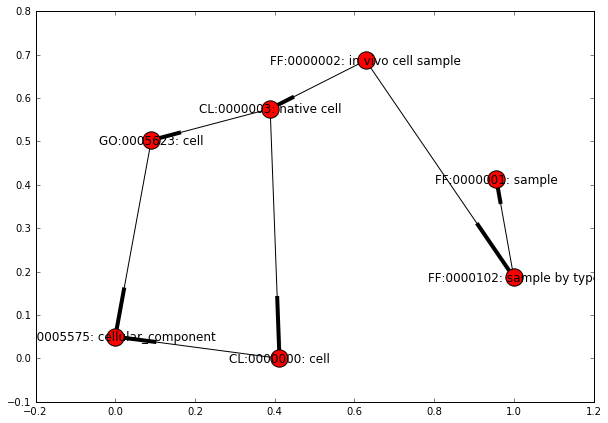

In [10]:
fig, ax = subplots(figsize=(10, 7))
nx.draw_networkx(G1_)

{'CL:0000000': <matplotlib.text.Text at 0x7f5e993598d0>,
 'CL:0000003': <matplotlib.text.Text at 0x7f5e99693390>,
 'FF:0000001': <matplotlib.text.Text at 0x7f5e99693e10>,
 'FF:0000002': <matplotlib.text.Text at 0x7f5e99685f98>,
 'FF:0000102': <matplotlib.text.Text at 0x7f5e99359e10>,
 'GO:0005575': <matplotlib.text.Text at 0x7f5e99359390>,
 'GO:0005623': <matplotlib.text.Text at 0x7f5e996938d0>}

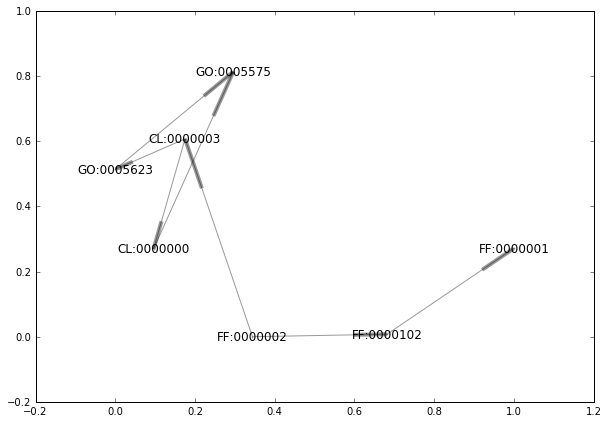

In [11]:
fig, ax = subplots(figsize=(10, 7))
pos = nx.spring_layout(G1)
nx.draw_networkx_nodes(G1,pos,node_size=.5,node_color='w',alpha=0.4)
nx.draw_networkx_edges(G1,pos,alpha=0.4,node_size=0,width=1,edge_color='k')
nx.draw_networkx_labels(G1,pos,fontsize=14)

#### Export to cytoscape
The plotting library is too slow for large graphs and one looses the overview anyway. Fortunately, we can export to `graphml` which can be opened in cytoscape

In [12]:
nx.write_graphml(G1_, "./ontology_network/test.graphml")

## Create Network from all samples
Let's first inspect the Network constructed by OBOOntology from the supergraphs of all samples in the fantom5 dataset:

In [13]:
import pandas as pd

In [14]:
col_vars = pd.read_csv("./data/column_vars.processed.csv")
sample_ids = list(col_vars["obo_id"])

In [15]:
G2 = obo.to_networkx(terms=sample_ids)

In [16]:
nx.write_graphml(G2, "./ontology_network/whole_ontology.graphml")

The resulting network (inspected in cytoscape) is huge, contains circles and contains a vast amount of unneccessary elements. Basically it contains the whole Ontology.
![whole network](img/explore_ontology_01.png)
**=> We need a more fine-grained solution:**

## Building the Networks manually
I build different networks recursively starting with different elements. 
All networks are visualized in cytoscape in [explore_ontology.cys](ontology_network/explore_ontology.cys)

In [17]:
obo.child_terms("FF:0000102") # sample by type

{OBOObject(id='FF:0000003', name=cell line sample, ...),
 OBOObject(id='FF:0000002', name=in vivo cell sample, ...),
 OBOObject(id='FF:0000004', name=tissue sample, ...)}

#### Structure starting from 'sample'

In [18]:
build_and_export_tree(obo, "FF:0000001", "./ontology_network/all_samples.graphml")
build_and_export_tree(obo, "FF:0000001", "./ontology_network/all_samples.depth4.graphml", 4)
build_and_export_tree(obo, "FF:0000001", "./ontology_network/all_samples.depth3.graphml", 3)

The graph has 4023 nodes
The graph has 2341 nodes
The graph has 307 nodes


We can observe three major categories: "experimentally modified", "by species" and "by type". 
For the cell signatures we are potentially interested in 'by species'->'human' and in the three subcategories of 'by type':
* cell line sample
* in vivo cell sample
* tissue sample

#### Structure starting from human sample

In [19]:
build_and_export_tree(obo, "FF:0000210", "./ontology_network/human_samples.graphml")
build_and_export_tree(obo, "FF:0000103", "./ontology_network/mouse_samples.graphml")

The graph has 2298 nodes
The graph has 1414 nodes


The resulting graph looks pretty confusing, too. This is due to the fact, that the root node has many direct immediate children. Deleting the root node reveals a bit more of the structure by splitting up the network. However it doesn't provide the hierarchy we would like to have. 

#### Sturcture starting from 'cell line sample'

In [20]:
build_and_export_tree(obo, "FF:0000003", "./ontology_network/cell_line_samples.graphml")
build_and_export_tree(obo, "FF:0000003", "./ontology_network/cell_line_samples.depth3.graphml", 3)

The graph has 1321 nodes
The graph has 208 nodes


That might be something we could work with... 
Probably I have to filter the results for 'is_a' 'human_sample' 
Contains basically only tumor samples

#### Structure starting from 'in vivo cell sample'

In [21]:
build_and_export_tree(obo, "FF:0000002", "./ontology_network/invivo_cell_samples.graphml")
build_and_export_tree(obo, "FF:0000002", "./ontology_network/invivo_cell_samples.depth3.graphml", 3)

The graph has 1236 nodes
The graph has 629 nodes


#### Structure starting from 'tissue sample'

In [22]:
build_and_export_tree(obo, "FF:0000004", "./ontology_network/tissue_samples.graphml")
build_and_export_tree(obo, "FF:0000004", "./ontology_network/tissue_samples.depth3.graphml", 3)

The graph has 890 nodes
The graph has 151 nodes


#### Supergraph of a hepatocyte (CNhs12340)

In [23]:
hepatograph = obo.to_networkx(terms=["FF:11523-119I2"])
nx.write_graphml(hepatograph, "./ontology_network/hepatocyte_supergraph.graphml")

## Analysing the Networks in cytoscape
Having investigated the different networks in cytoscape, I decided to work with the network based on 'human sample'. 
When removing the root-node the network falls apart into its subgraphs. We note, that there are few big subgraphs with a multi-level hierarchical annotation. Apart from that there is a notable amount of "3-stars" and "2-stars", mostly biological replicates and also a notable amount of singletons. 

![Network human samples remove parent](img/explore_ontology_02.png)



## Quality control of the network
Here, I try to identify further problems with the network. Let's first review what we know about the FANTOM5 Dataset:

#### From the F5 paper (Nature 2014): 
* 573 human primary cell samples (3 donors for most cell types) 
* 128 mouse primary cell samples
* 250 cancer cell lines
* 152 human post-mortem-tissues
* 271 mouse developmental tissue samples

In [24]:
573+128+250+152+271

1374

without mouse

In [25]:
573+250+152

975

### Are there human samples missing in the network? 
I check if the network contains all human samples that are contained in the hsa expression data file downloaded form the F5 website. There are 16 samples missing. 

**Note**: I also did the comparison with the network based on 'sample by type'. I noticed that this networks lacks many human samples (data not shown) 

In [27]:
col_vars = pd.read_csv("data/column_vars.processed.csv", index_col=0)

In [28]:
obo = OBOOntology()
obo.load(open("data/ff-phase2-140729.obo"))

#### Build the graph based on 'human samples'

In [29]:
hsa_samples = relabel_nodes(obo, build_tree(obo, "FF:0000210"))
hsa_samples = annotate_graph(hsa_samples, col_vars)

In [30]:
contained_samples = [s for s in hsa_samples.nodes() if is_sample_id(s)]
col_obo_ids = set(col_vars["obo_id"])
hsa_obo_ids = set([x.split()[0][:-1] for x in hsa_samples.nodes()])

In [31]:
print("number of nodes in network: ", len(hsa_obo_ids))
print("number of samples in network: ", len(contained_samples))
print("number of samples in data table: ", len(col_obo_ids))
print("intersection: ", len(col_obo_ids & hsa_obo_ids))

number of nodes in network:  2298
number of samples in network:  1800
number of samples in data table:  1816
intersection:  1800


That means that all 1800 human samples in the network are contained in the datatable. 
However, 16 samples are in the data table that are not annotated as human sample in the ontology: 

In [32]:
missing_samples = sorted([tag2name(obo, n) for n in col_obo_ids.difference(hsa_obo_ids)])
missing_samples

['FF:10150-102I6: medial frontal gyrus, adult, donor10252',
 'FF:11914-125G6: CD4+CD25-CD45RA- memory conventional T cells expanded, donor2',
 'FF:11915-125G7: CD4+CD25+CD45RA+ naive regulatory T cells expanded, donor2',
 'FF:11918-125H1: CD4+CD25-CD45RA- memory conventional T cells expanded, donor3',
 'FF:11919-125H2: CD4+CD25+CD45RA+ naive regulatory T cells expanded, donor3',
 'FF:11937-126A2: gamma delta positive T cells, donor1',
 'FF:11938-126A3: gamma delta positive T cells, donor2',
 'FF:11939-126A4: Mast cell, expanded, donor5',
 'FF:11940-126A5: Mast cell, expanded and stimulated, donor5',
 'FF:11941-126A6: Mast cell, expanded, donor8',
 'FF:11942-126A7: Mast cell, expanded and stimulated, donor8',
 'FF:13364-143F7: HES3-GFP Embryonic Stem cells, cardiomyocytic induction, day00, biol_rep1 (UH-1)',
 'FF:13365-143F8: HES3-GFP Embryonic Stem cells, cardiomyocytic induction, day00, biol_rep2 (UH-2)',
 'FF:13424-144D4: iPS differentiation to neuron, control donor C11-CRL2429, day1

In [33]:
with open("data/missing_samples.txt", 'w') as f:
    for ms in missing_samples:
        f.write(ms + "\n")

By looking at the network, one can find that most of the samples have simply been forgotten:
`FF:13364-143F7: HES3-GFP Embryonic Stem cells, cardiomyocytic induction, day00, biol_rep1 (UH-1)` fits perfectly to `FF:13366-143F9: HES3-GFP Embryonic Stem cells, cardiomyocytic induction, day00, biol_rep3 (UH-3)` which exists as a singleton in the network. 

### But what has happend to the samples? 
Actually, the samples must exist within the ontology (I checked that in the process_headers step). Thus, simply the annotation as human sample is missing. 

I note, that some of the samples are flagged with a comment, that the annotation is not complete: 

In [45]:
missing_sample_ids = [x.split()[0][:-1] for x in missing_samples]
for obo_id in missing_sample_ids: 
    term = obo.term(obo_id)
    tags = term.tags()
    for tag, value, _, _ in tags: 
        if tag == "comment":
            print(tag, value)

comment Changed from previous label. TODO: full classification
comment Changed from previous label. TODO: full classification
comment Changed from previous label. TODO: full classification
comment Changed from previous label. TODO: full classification
comment Previously: UH-1, rep1. TODO: full classification
comment Previously: UH-2, rep1. TODO: full classification


## Conclusion
The network is something we can work with. The major problems are: 
* Missing entries
* The vast amount of singletons

I address these problems in the notebook `improve_network.ipynb`